### Исследование поведения пользователей в мобильном приложении

<b>Задачи  исследования</b>:
<ul>
<li>Проанализировать связь целевого события — просмотра контактов — и других действий пользователей</li>
<li>Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.</li>
</ul>
<b>Цели исследования</b>:
<ul>
<li>Данные о поведении пользователей позволят эффективно управлять вовлеченностью клиентов.</li>
<li>Получить на основе поведения пользователей гипотезы о том как можно было бы улучшить приложение с точки зрения пользовательского опыта.</li>
</ul>

#### Описание данных

В нашем распоряжении два датасета - с источниками и действиями пользователей.

Датасет mobile_sources:
<ul>
<li>userId — идентификатор пользователя,</li>
<li>source — источник, с которого пользователь установил приложение.</li>
</ul>
Датасет mobile_dataset:
<ul>
<li>event.time — время совершения,</li>
<li>user.id — идентификатор пользователя,</li>
<li>event.name — действие пользователя.</li>
</ul>
Виды действий:
<ul>
<li>advert_open — открыл карточки объявления,</li>
<li>photos_show — просмотрел фотографий в объявлении,</li>
<li>tips_show — увидел рекомендованные объявления,</li>
<li>tips_click — кликнул по рекомендованному объявлению,</li>
<li>contacts_show и show_contacts — посмотрел номер телефона,</li>
<li>contacts_call — позвонил по номеру из объявления,</li>
<li>map — открыл карту объявлений,</li>
<li>search_1 — search_7 — разные действия, связанные с поиском по сайту,</li>
<li>favorites_add — добавил объявление в избранное.</li>
</ul>

#### Изучение данных
<ul>
<li>Какая информация есть в датасете, неверные названия колонок, возможные пропуски</li>
<li>Изучим типы данных</li>
<li>Изучим, за какой период представлена информация</li>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly import graph_objs as go
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
import math as mth

In [2]:
data_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
data_sources.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
data.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


В датасетах некорректное написание столбцов.

In [4]:
data_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


В датасете с действиями пользователей неверный тип данных во времени события.

##### Промежуточные выводы по изучению данных:

В ходе изучения данных было выявлено:
<ul>
    <li>некорректное написание названий столбцов,</li>
    <li>некорректный тип данных столбца event_time,</li>
</ul>
Устраним эти недостатки во время предобработки данных.

#### Предобработка данных
<ul>
<li>Переименуем колонки</li>
<li>Измененим типа данных в колонке event_time</li>
<li>Проверим данные на пропуски и дубликаты</li>
<li>Изучим, за какой период предоставлены данные</li>
<li>Посчитаем аномальных пользователей, решим вопрос с их возможным удалением</li>
</ul>

##### Переименуем колонки

In [6]:
data_sources.rename(columns={'userId': 'user_id'}, inplace=True)
data_sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [7]:
data.rename(columns={'user.id': 'user_id'}, inplace=True)
data.rename(columns={'event.time': 'event_time'}, inplace=True)
data.rename(columns={'event.name': 'event_name'}, inplace=True)
data.head()

,event_time,event_name,user_id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


##### Изменим тип данных в колонке event_time

In [8]:
data['event_time'] = pd.to_datetime(data['event_time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


##### Проверим данные на пропуски

In [9]:
data.isnull().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [10]:
data_sources.isnull().sum()

user_id    0
source     0
dtype: int64

Пропусков не обнаружено.

##### Проверим данные на дубликаты

In [11]:
data.duplicated().sum()

0

In [12]:
data_sources.duplicated().sum()

0

Дубликатов в датасетах не было обнаружено.

##### Изучим, за какое время предоставлены данные

In [13]:
max_date = data['event_time'].max()
min_date = data['event_time'].min()

display("Максимальная дата:", max_date)
display("Минимальная дата:", min_date)

'Максимальная дата:'

Timestamp('2019-11-03 23:58:12.532487')

'Минимальная дата:'

Timestamp('2019-10-07 00:00:00.431357')

##### Найдем аномальных пользователей через количество событий

In [14]:
events_per_user = data.groupby('user_id')['event_time'].count().reset_index()
events_per_user.describe()

,event_time
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


In [15]:
events_per_user.rename(columns={'user_id': 'user_id', 'event_time': 'event_count'}, inplace=True)

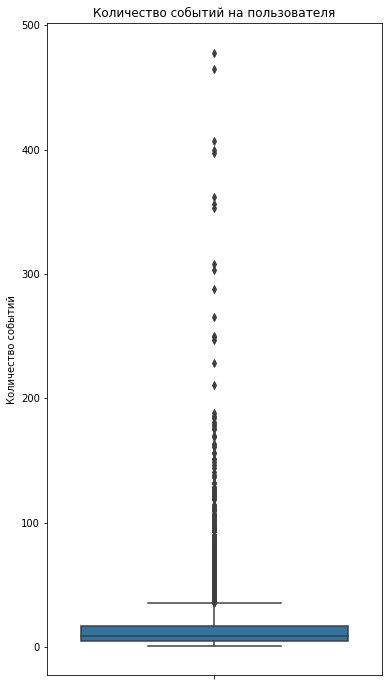

In [16]:
plt.figure(figsize=(6, 12))
sns.boxplot(y=events_per_user['event_count'])

plt.title('Количество событий на пользователя')
plt.ylabel('Количество событий')
plt.show()


По графику видно, что начиная где-то с 200 событий, начинается много аномальных значений.

In [17]:
np.percentile(events_per_user['event_count'], [90, 95, 99])

array([ 36.,  59., 132.])

Не более 5% пользователей совершили 59 событий и не более 1% 132 события.

90% значений событий на одного пользователя меньше или равны 36.
95% значений меньше или равны 59.
99% значений меньше или равны 132. Т.е. событий более 132 меньше одного процента и разрыв от количества событий для большинства пользователей не существенен, можно их не удалять.

##### Промежуточные выводы по предобработке данных.

Во время предобработки данных выполнено:
<ul>
    <li>Переименованы колонки в датасетах.</li>
    <li>Заменен тип данных в колонке event_date.</li>
    <li>Проверка на пропуски и дубликаты - не обнаружено.</li>
    <li>Проверка на аномальное количество событий - их процент довольно велик, было принято решение не удалять данные, чтобы не повлиять на общую картину.</li>
</ul>    

Датасет располагает информацией за 7 октября - 11 ноября 2019 года.

#### Исследование данных
<ul>
<li>Отсортируем по user_id и event_time</li>
<li>Выделим колонку с сессиями.</li>
<li>Найдем длительность каждой сессии и среднюю длительность сессии.</li>
<li>Изучим, какие события есть в датасете, как часто они встречаются.</li>
<li>Оценим пользовательскую активность - посчитаем DAU и MAU</li>
<li>Посчитаем долю пользователей, совершивших целевое событие - просмотр контактов</li>    
<li>Избавимся от повторяющихся событий в рамках сессии.</li>   
<li>Найдем сценарии, которые приводят к просмотру контактов.</li>
</ul>

##### Отсортируем данные по user_id и event_time

In [18]:
sorted_data = data.sort_values(['user_id', 'event_time'])

##### Добавим колонку с сессиями и удалим повторяющиеся события

In [19]:
g = (sorted_data.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()

sorted_data['session_id'] = sorted_data.groupby(['user_id', g], sort=False).ngroup() + 1
sorted_data_new = sorted_data.drop_duplicates(subset=['session_id', 'event_name'])
sorted_data_new.head()

,event_time,event_name,user_id,session_id
805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
6541,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2
6565,2019-10-09 18:40:28.738785,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2
36412,2019-10-21 19:52:30.778932,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3
36419,2019-10-21 19:53:38.767230,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3


Основываясь на дефолтных данных Яндекс Метрики, за тайм-аут считаю 30 мин: https://yandex.ru/support/metrica/general/glossary.html

##### Найдем среднюю длительность сессии.

In [20]:
sessions = sorted_data.groupby(['user_id', 'session_id'])

session_durations = sessions['event_time'].apply(lambda x: x.max() - x.min())


average_session_duration = session_durations.median()

display("Средняя длительность сессии:", average_session_duration)

'Средняя длительность сессии:'

Timedelta('0 days 00:05:35.169711500')

##### Найдем длительность каждой сессии, время ее начала и окончания.

In [21]:
sessions_df = sorted_data.pivot_table(
    index=['user_id', 'session_id'],
    values='event_time',
    aggfunc=lambda x: x.max() - x.min()
).reset_index()

sessions_df[['max_time', 'min_time']] = sorted_data.groupby(['user_id', 'session_id'])['event_time'].agg(['max', 'min']).reset_index(drop=True)

sessions_df = sessions_df.rename(columns={'event_time': 'session_duration', 'max_time': 'last_time', 'min_time': 'first_time'})

sessions_df.head()


,user_id,session_id,session_duration,last_time,first_time
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,0 days 00:09:55.727258,2019-10-07 13:49:41.716617,2019-10-07 13:39:45.989359
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,0 days 00:08:27.385985,2019-10-09 18:42:22.963948,2019-10-09 18:33:55.577963
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,0 days 00:14:59.272096,2019-10-21 20:07:30.051028,2019-10-21 19:52:30.778932
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:12:38.171767,2019-10-22 11:30:52.807203,2019-10-22 11:18:14.635436
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,0 days 00:25:20.787329,2019-10-19 21:59:54.637098,2019-10-19 21:34:33.849769


##### Найдем количество сессий для каждого пользователя.

In [22]:
sessions_per_user = sessions_df.groupby('user_id').size().reset_index(name='session_count')
sessions_per_user = sessions_per_user.sort_values(by='session_count', ascending=False)

sessions_per_user.head()

,user_id,session_count
615,21230dd9-2f7f-4b77-a436-43d4d10388e0,99
401,1580911b-65db-4f1a-be7e-1ca39becac30,52
3397,cb36854f-570a-41f4-baa8-36680b396370,50
1668,6383ff6a-04b8-4562-a98f-bb4f760d3c39,45
3794,e13f9f32-7ae3-4204-8d60-898db040bcfc,38


Пользователь-лидер совершил почти 100 сессий в приложении.

##### Найдем наибольшее и наименьшее количество сессий.

In [23]:
sessions_per_user.describe()

,session_count
count,4293.000000
mean,2.415094
std,3.536466
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,99.000000


Самое маленькое количество сессий, совершенное одним пользователем - 1.

##### Изучим, какие события есть в датасете, как часто они встречаются.

In [24]:
events = sorted_data.groupby('event_name')['event_time'].count().reset_index()
events.rename(columns={'event_name': 'event_name', 'event_time': 'count'}, inplace=True)
events

,event_name,count
0,advert_open,6164
1,contacts_call,541
2,contacts_show,4450
3,favorites_add,1417
4,map,3881
5,photos_show,10012
6,search_1,3506
7,search_2,324
8,search_3,522
9,search_4,701


##### Сгруппируем все события по поиску в одно search

In [25]:
search_events = events[events['event_name'].str.startswith('search_')]

search_count = search_events['count'].sum()

combined_search_event = pd.DataFrame({'event_name': ['search'], 'count': [search_count]})

events = events.drop(search_events.index)

events = pd.concat([events, combined_search_event])

display(events)

,event_name,count
0,advert_open,6164
1,contacts_call,541
2,contacts_show,4450
3,favorites_add,1417
4,map,3881
5,photos_show,10012
13,show_contacts,79
14,tips_click,814
15,tips_show,40055
0,search,6784


##### Объединим события show_contacts и contacts_show

In [26]:
show_contacts_count = events[events['event_name'].isin(['contacts_show', 'show_contacts'])]['count'].sum()

events.loc[events['event_name'] == 'show_contacts', 'count'] = show_contacts_count

events = events[events['event_name'] != 'contacts_show']

display(events)


,event_name,count
0,advert_open,6164
1,contacts_call,541
3,favorites_add,1417
4,map,3881
5,photos_show,10012
13,show_contacts,4529
14,tips_click,814
15,tips_show,40055
0,search,6784


##### Изучим количество событий по графику

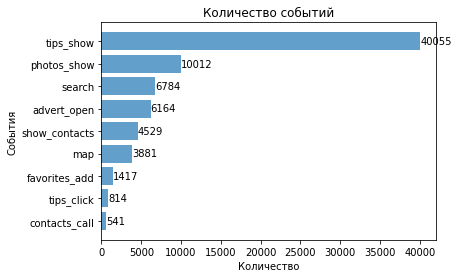

In [27]:
events_sorted = events.sort_values(by='count', ascending=True)

plt.barh(events_sorted['event_name'], events_sorted['count'], align='center', alpha=0.7)
plt.xlabel('Количество')
plt.ylabel('События')
plt.title('Количество событий')

for i, count in enumerate(events_sorted['count']):
    plt.text(count, i, str(count), ha='left', va='center')

plt.show()

Наиболее часто встречающееся событие – когда пользователь увидел рекомендованное объявление, самое редко встречающееся событие – когда пользователь совершает звонок.

##### Оценим пользовательскую активность - посчитаем DAU и WAU

Поскольку данные собраны за месяц, посчитать ежедневную и недельную активность пользователей, преобразуем данные о времени и выделим год, месяц и неделю начала сессии в отдельные столбцы. 

In [28]:
sessions_df['session_year'] = sessions_df['first_time'].dt.year
sessions_df['session_month'] = sessions_df['first_time'].dt.month
sessions_df['session_week'] = sessions_df['first_time'].dt.isocalendar().week
sessions_df['session_date'] = sessions_df['first_time'].dt.date
sessions_df.head()

,user_id,session_id,session_duration,last_time,first_time,session_year,session_month,session_week,session_date
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,0 days 00:09:55.727258,2019-10-07 13:49:41.716617,2019-10-07 13:39:45.989359,2019,10,41,2019-10-07
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,0 days 00:08:27.385985,2019-10-09 18:42:22.963948,2019-10-09 18:33:55.577963,2019,10,41,2019-10-09
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,0 days 00:14:59.272096,2019-10-21 20:07:30.051028,2019-10-21 19:52:30.778932,2019,10,43,2019-10-21
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,0 days 00:12:38.171767,2019-10-22 11:30:52.807203,2019-10-22 11:18:14.635436,2019,10,43,2019-10-22
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,0 days 00:25:20.787329,2019-10-19 21:59:54.637098,2019-10-19 21:34:33.849769,2019,10,42,2019-10-19


In [29]:
dau_total = (
    sessions_df.groupby('session_date').agg({'user_id': 'nunique'}).mean()
)

wau_total = (
    sessions_df.groupby(['session_year', 'session_week'])
    .agg({'user_id': 'nunique'})
    .mean()
)

display('Ежедневных активных пользователей:', int(dau_total))
display('Еженедельных активных пользователей:', int(wau_total))

'Ежедневных активных пользователей:'

277

'Еженедельных активных пользователей:'

1381

##### Посчитаем долю пользователей, совершивших целевое событие - просмотр контактов

In [30]:
total_users = sorted_data['user_id'].nunique()

target_users_count = sorted_data[sorted_data['event_name'].isin(['show_contacts', 'contacts_show'])]['user_id'].nunique()

target_users_fraction = target_users_count / total_users

display("Доля пользователей, совершивших целевое действие:", target_users_fraction)


'Доля пользователей, совершивших целевое действие:'

0.22851153039832284

##### Соединим сессии с пользователями

In [31]:
sorted_data_new.loc[sorted_data_new['event_name'].str.startswith('search_'), 'event_name'] = 'search'
sorted_data_new['event_name'] = sorted_data_new['event_name'].replace('contacts_show', 'show_contacts')

session_user_counts = sorted_data_new.groupby('session_id')['user_id'].nunique().reset_index()
session_user_counts.columns = ['session_id', 'user_count']

unique_events = sorted_data_new.merge(session_user_counts, on='session_id', how='left')

grouped_events = unique_events.groupby('session_id').agg({'event_name': list, 'user_id': list}).reset_index()
display(grouped_events.head(10))


/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/tmp/ipykernel_497/3720203181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data_new['event_name'] = sorted_data_new['event_name'].replace('contacts_show', 'show_contacts')


,session_id,event_name,user_id
0,1,[tips_show],[0001b1d5-b74a-4cbf-aeb0-7df5947bf349]
1,2,"[map, tips_show]","[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d..."
2,3,"[tips_show, map]","[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d..."
3,4,"[map, tips_show]","[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d..."
4,5,"[search, photos_show]","[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
5,6,"[search, photos_show, favorites_add, show_cont...","[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
6,7,"[photos_show, advert_open]","[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
7,8,"[search, photos_show, show_contacts, contacts_...","[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
8,9,"[search, photos_show, show_contacts]","[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
9,10,[show_contacts],[00157779-810c-4498-9e05-a1e9e3cedf93]


Переведем данные из столбца event_name в строки.

In [32]:
grouped_events['event_name_list'] = grouped_events['event_name'].apply(', '.join)
grouped_events_new = grouped_events.drop(columns=['event_name'])

grouped_events_new.head()

,session_id,user_id,event_name_list
0,1,[0001b1d5-b74a-4cbf-aeb0-7df5947bf349],tips_show
1,2,"[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d...","map, tips_show"
2,3,"[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d...","tips_show, map"
3,4,"[0001b1d5-b74a-4cbf-aeb0-7df5947bf349, 0001b1d...","map, tips_show"
4,5,"[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777...","search, photos_show"


##### Найдем сценарии, которые приводят к просмотру контактов.

In [33]:
filtered_grouped_events = grouped_events_new[grouped_events_new['event_name_list'].apply(lambda x: 'show_contacts' in x)]
display(filtered_grouped_events.head(10))

,session_id,user_id,event_name_list
5,6,"[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777...","search, photos_show, favorites_add, show_conta..."
7,8,"[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777...","search, photos_show, show_contacts, contacts_c..."
8,9,"[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777...","search, photos_show, show_contacts"
9,10,[00157779-810c-4498-9e05-a1e9e3cedf93],show_contacts
17,18,"[00551e79-152e-4441-9cf7-565d7eb04090, 00551e7...","show_contacts, contacts_call"
18,19,"[00551e79-152e-4441-9cf7-565d7eb04090, 00551e7...","search, show_contacts, contacts_call"
22,23,"[005fbea5-2678-406f-88a6-fbe9787e2268, 005fbea...","show_contacts, tips_show"
26,27,[00753c79-ea81-4456-acd0-a47a23ca2fb9],show_contacts
29,30,"[007d031d-5018-4e02-b7ee-72a30609173f, 007d031...","map, tips_show, show_contacts"
31,32,"[00a93a72-3bbc-4ee7-8a81-7134f45ae009, 00a93a7...","show_contacts, search"


In [34]:
sorted_data.loc[sorted_data['event_name'].str.startswith('search_'), 'event_name'] = 'search'
sorted_data['event_name'] = sorted_data['event_name'].replace('contacts_show', 'show_contacts')

In [35]:
filtered_grouped_events = filtered_grouped_events.groupby('event_name_list').agg({'session_id': 'nunique', 'user_id': 'first'}).reset_index()

filtered_grouped_events = filtered_grouped_events.sort_values(by='session_id', ascending=False)

filtered_grouped_events.groupby('session_id')['event_name_list'].apply(tuple)

filtered_grouped_events.head(10)


,event_name_list,session_id,user_id
201,"tips_show, show_contacts",342,"[0103a07d-513f-42b9-8d91-d5891d5655fe, 0103a07..."
134,show_contacts,195,[00157779-810c-4498-9e05-a1e9e3cedf93]
138,"show_contacts, contacts_call",120,"[00551e79-152e-4441-9cf7-565d7eb04090, 00551e7..."
51,"map, tips_show, show_contacts",94,"[007d031d-5018-4e02-b7ee-72a30609173f, 007d031..."
67,"photos_show, show_contacts",85,"[01d283e1-cb1c-407a-a4e0-9f72f3deecca, 01d283e..."
172,"show_contacts, tips_show",73,"[005fbea5-2678-406f-88a6-fbe9787e2268, 005fbea..."
121,"search, show_contacts, contacts_call",54,"[00551e79-152e-4441-9cf7-565d7eb04090, 00551e7..."
87,"search, photos_show, show_contacts",45,"[00157779-810c-4498-9e05-a1e9e3cedf93, 0015777..."
120,"search, show_contacts",44,"[03bef3ef-cce8-46ed-8c70-414b6b0486fb, 03bef3e..."
158,"show_contacts, photos_show",38,"[0420f4cf-29ec-44c6-af9c-247f36efea68, 0420f4c..."


Выберем три самых распространенных сценария для построения воронок: 
    
    tips_show, show_contacts;
    show_contacts, contacts_call;
    map, tips_show, show_contacts.

##### Промежуточные выводы:
<ul>
<li>Cредняя длительность сессии 5 минут, 35 секунд.</li>
<li>Самое большое количество сессий у одного пользователя – 99.</li>
<li>Самое маленькое количество сессий, совершенное одним пользователем - 1.</li>
<li>Наиболее часто встречающееся событие – когда пользователь увидел рекомендованное объявление, самое редко встречающееся событие – когда пользователь совершает звонок.</li>
<li>В приложении 277 активных пользователей ежедневно и 1381 активный пользователь еженедельно.</li>
<li>Чуть более 20% пользователей совершили целевое действие – просмотр контактов.</li>
</ul>

#### Основные вопросы исследования

1. Проанализируем связь целевого события — просмотра контактов — и других действий пользователей
<ul>
<li>В разрезе сессий отберем 3-4 сценария\паттерна, которые приводят к просмотру контактов</li>
<li>Построим воронки по основным сценариям в разрезе уникальных пользователей</li>
</ul>


2. Оценим, какие действия чаще совершают те пользователи, которые просматривают контакты

Рассчитаем относительную частоту событий в разрезе двух групп пользователей:
<ul>
<li>группа пользователей, которые смотрели контакты contacts_show</li>
<li>группа пользователей, которые не смотрели контакты contacts_show</li>
</ul>


На этапе исследования данных мы выбрали три сценария, которые приводят к просмотру контактов:
<ul>
<li>tips_show, show_contacts;</li>
<li>map, tips_show, show_contacts;</li>
<li>show_contacts,contacts_call.</li>
</ul>

##### Построим воронки по этим сценариям в разрезе уникальных пользователей

Построим воронку для сценария tips_show, show_contacts.

In [36]:
steps = ['tips_show', 'show_contacts']

In [37]:
def create_funnel_df(sorted_data, steps, from_date=None, to_date=None, step_interval=0):
    sorted_data = sorted_data[['user_id', 'event_name', 'event_time']]
    sorted_data = sorted_data[sorted_data['event_name'].isin(steps)]

    values = []
    dfs = {}
    for i, step in enumerate(steps):
        if i == 0:
            dfs[step] = sorted_data[sorted_data['event_name'] == step] \
                .sort_values(['user_id', 'event_time'], ascending=True) \
                .drop_duplicates(subset=['user_id', 'event_name'], keep='first')

            if from_date:
                dfs[step] = dfs[step][(dfs[step]['event_time'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['event_time'] <= to_date)]

        else:
            dfs[step] = sorted_data[sorted_data['event_name'] == step]

            merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='user_id', how='outer')

            valid_ids = dfs[steps[i - 1]]['user_id'].unique()
            merged = merged[merged['user_id'].isin(valid_ids)]

            merged = merged[merged['event_time_y'] >=
                (merged['event_time_x'] + pd.to_timedelta(step_interval, unit='days'))].sort_values('event_time_y', ascending=True)

            merged = merged.drop_duplicates(subset=['user_id', 'event_name_x', 'event_name_y'], keep='first')

            merged = merged[['user_id', 'event_name_y', 'event_time_y']].rename({'event_name_y': 'event_name',
                                                                         'event_time_y': 'event_time'}, axis=1)

            dfs[step] = merged

        values.append(len(dfs[step]))

    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    funnel_df['val-1'] = funnel_df['val'].shift(1)
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df

result_df = create_funnel_df(sorted_data, steps)

result_df.head()

,step,val,pct,val-1,pct_from_first
0,tips_show,2801,100,NaN,100
1,show_contacts,496,17,2801.0,17


In [38]:
def group_funnel_dfs(sorted_data, steps, col):
    dict_ = {}
    
    ids = dict(sorted_data.groupby([col])['user_id'].apply(set))

    for entry in sorted_data[col].dropna().unique():
        ids_list = ids[entry]
        df = sorted_data[sorted_data['user_id'].isin(ids_list)].copy()
        if len(df[df['event_name'] == steps[0]]) > 0:
            dict_[entry] = create_funnel_df(df, steps)

    return dict_

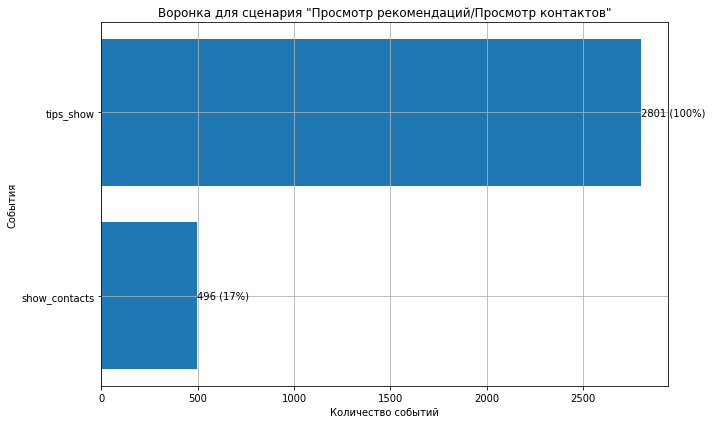

In [39]:
def plot_stacked_funnel(sorted_data, steps, col=None, from_date=None, to_date=None, step_interval=0):
    data = []
    if col:
        dict_ = group_funnel_dfs(sorted_data, steps, col)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(sorted_data, steps, from_date=from_date, to_date=to_date, step_interval=step_interval)
        dict_ = {'Total': funnel_df}
        title = 'Воронка для сценария "Просмотр рекомендаций/Просмотр контактов"'

    for t in dict_.keys():
        plt.figure(figsize=(10, 6))
        plt.barh(dict_[t].step.values, dict_[t].val.values)
        for i, val in enumerate(dict_[t].val.values):
            plt.text(val, i, str(val) + " (" + str(dict_[t]['pct'].values[i]) + "%)", ha='left', va='center')
        plt.xlabel('Количество событий')
        plt.ylabel('События')
        plt.title(title)
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

steps = ['tips_show', 'show_contacts']
plot_stacked_funnel(sorted_data, steps, from_date="2010-10-07", to_date="2019-11-11")

По графику видно, что после просмотра рекламного объявления только около 20% пользователей дошли до второго шага - просмотра номера телефона.

Рассмотрим второй сценарий - map, tips_show, show_contacts.

In [40]:
steps = ['map','tips_show', 'show_contacts']

result_df = create_funnel_df(sorted_data, steps)

result_df.head()

,step,val,pct,val-1,pct_from_first
0,map,1456,100,NaN,100
1,tips_show,1312,90,1456.0,90
2,show_contacts,224,17,1312.0,15


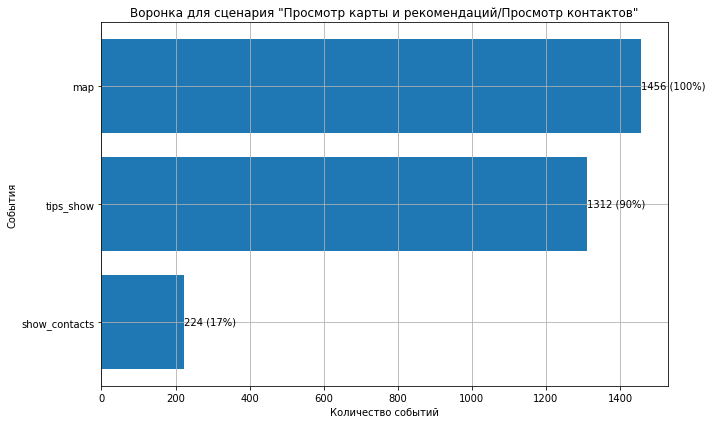

In [41]:
def plot_stacked_funnel(sorted_data, steps, col=None, from_date=None, to_date=None, step_interval=0):
    data = []
    if col:
        dict_ = group_funnel_dfs(sorted_data, steps, col)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(sorted_data, steps, from_date=from_date, to_date=to_date, step_interval=step_interval)
        dict_ = {'Total': funnel_df}
        title = 'Воронка для сценария "Просмотр карты и рекомендаций/Просмотр контактов"'

    for t in dict_.keys():
        plt.figure(figsize=(10, 6))
        plt.barh(dict_[t].step.values, dict_[t].val.values)
        for i, val in enumerate(dict_[t].val.values):
            plt.text(val, i, str(val) + " (" + str(dict_[t]['pct'].values[i]) + "%)", ha='left', va='center')
        plt.xlabel('Количество событий')
        plt.ylabel('События')
        plt.title(title)
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

steps = ['map','tips_show', 'show_contacts']
plot_stacked_funnel(sorted_data, steps, from_date="2010-10-07", to_date="2019-11-11")

После просмотра карты объявлений всего 10% пользователей отвалилось при переходе на рекомендованные объявления, однако до просмотра контактов дошло всего 17% пользователей. 

Рассмотрим третий сценарий - show_contacts, contacts_call.

In [42]:
steps = ['show_contacts', 'contacts_call']

result_df = create_funnel_df(sorted_data, steps)

result_df.head()

,step,val,pct,val-1,pct_from_first
0,show_contacts,981,100,NaN,100
1,contacts_call,213,21,981.0,21


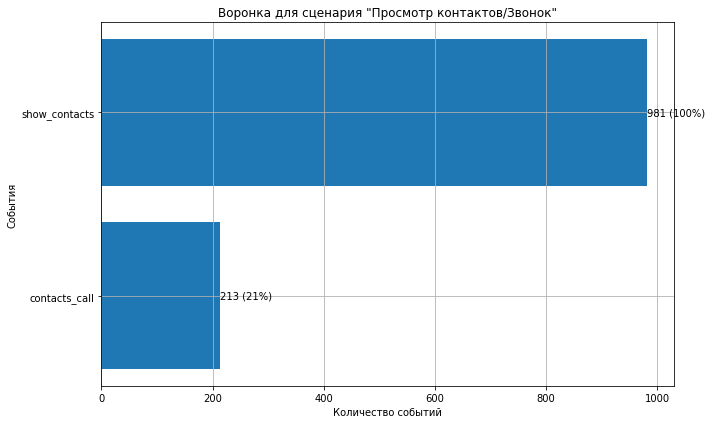

In [43]:
def plot_stacked_funnel(sorted_data, steps, col=None, from_date=None, to_date=None, step_interval=0):
    data = []
    if col:
        dict_ = group_funnel_dfs(sorted_data, steps, col)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(sorted_data, steps, from_date=from_date, to_date=to_date, step_interval=step_interval)
        dict_ = {'Total': funnel_df}
        title = 'Воронка для сценария "Просмотр контактов/Звонок"'

    for t in dict_.keys():
        plt.figure(figsize=(10, 6))
        plt.barh(dict_[t].step.values, dict_[t].val.values)
        for i, val in enumerate(dict_[t].val.values):
            plt.text(val, i, str(val) + " (" + str(dict_[t]['pct'].values[i]) + "%)", ha='left', va='center')
        plt.xlabel('Количество событий')
        plt.ylabel('События')
        plt.title(title)
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

steps = ['show_contacts', 'contacts_call']
plot_stacked_funnel(sorted_data, steps, from_date="2010-10-07", to_date="2019-11-11")

Только около 20% людей дошли до объявления до звонка.

##### Выделим пользователей, которые смотрели контакты show_contacts и которые не смотрели контакты.

In [44]:
contacts_users = sorted_data.query('event_name=="show_contacts"')['user_id'].unique().tolist()
display("Кол-во пользователей, посмотревших контакты:", len(contacts_users))

'Кол-во пользователей, посмотревших контакты:'

981

In [45]:
all_users = sorted_data['user_id'].unique()
display("Кол-во всех пользователей:", len(all_users))

'Кол-во всех пользователей:'

4293

In [46]:
no_contacts_users = list( set(all_users) - set(contacts_users) )
display("Кол-во пользователей, не просмотревших контакты:", len(no_contacts_users))

'Кол-во пользователей, не просмотревших контакты:'

3312

##### Сравним их действия

In [47]:
no_contacts_events = sorted_data.query('user_id==@no_contacts_users')['event_name'].value_counts()
no_contacts_events

tips_show        27287
photos_show       6184
search            4700
advert_open       4575
map               2780
favorites_add      993
tips_click         481
Name: event_name, dtype: int64

In [48]:
contacts_events = sorted_data.query('user_id==@contacts_users')['event_name'].value_counts()
contacts_events

tips_show        12768
show_contacts     4529
photos_show       3828
search            2084
advert_open       1589
map               1101
contacts_call      541
favorites_add      424
tips_click         333
Name: event_name, dtype: int64

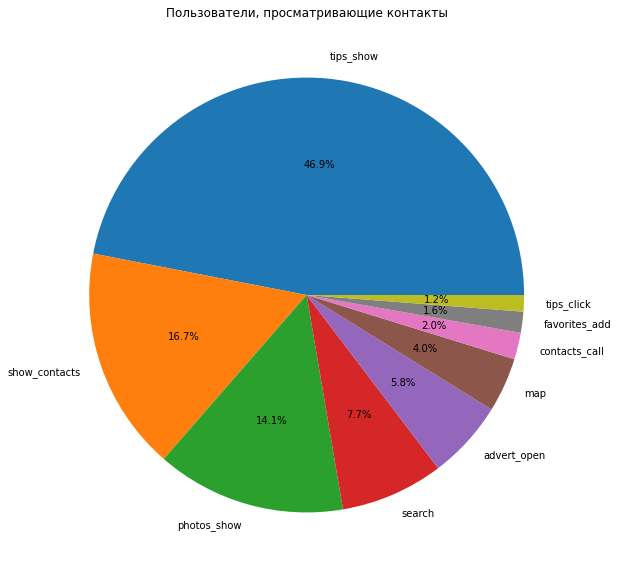

In [49]:
events_colors_contacts = {
    'tips_show': '#1f77b4',  
    'show_contacts': '#ff7f0e',  
    'photos_show': '#2ca02c',  
    'search': '#d62728',  
    'advert_open': '#9467bd',  
    'map': '#8c564b',  
    'contacts_call': '#e377c2',  
    'favorites_add': '#7f7f7f',  
    'tips_click': '#bcbd22'  
}
plt.figure(figsize=(10,10))
plt.pie(contacts_events.values, labels=contacts_events.index, autopct='%1.1f%%', colors=events_colors_contacts.values())
plt.title('Пользователи, просматривающие контакты');

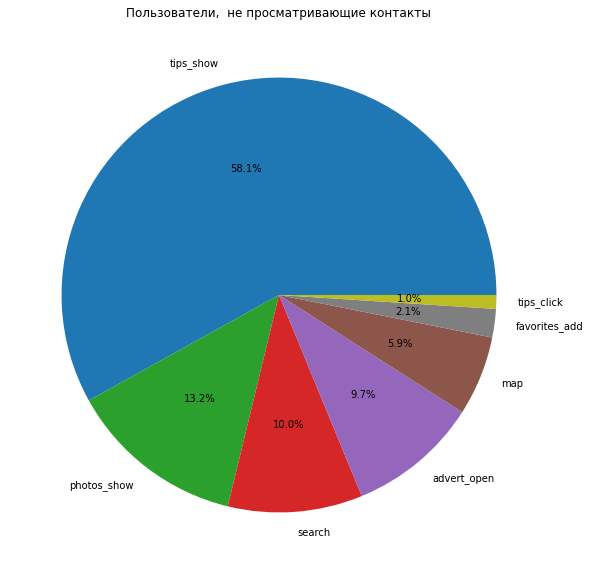

In [50]:
events_colors_no_contacts = {
    'tips_show': '#1f77b4',  
    'photos_show': '#2ca02c',  
    'search': '#d62728',  
    'advert_open': '#9467bd', 
    'map': '#8c564b',  
    'favorites_add': '#7f7f7f',  
    'tips_click': '#bcbd22'
}

plt.figure(figsize=(10,10))
plt.pie(no_contacts_events.values, labels=no_contacts_events.index, autopct='%1.1f%%', colors=events_colors_no_contacts.values())
plt.title('Пользователи,  не просматривающие контакты');
plt.show();

По графику видно, что у тех, кто не просматривал контакты, нет события contacts_call, что логично - без контактов нельзя позвонить.Люди, совершившие целевое событие больше просматривают фотографии, но меньше открывают карточки объявлений.

#### Статистическое исследование

<b>Гипотеза 1.</b>

H0 - Конверсия в просмотры контактов одинаковая у пользователей, которые совершают действия tips_show и tips_click и тех, которые совершают только tips_show.

H1 - Конверсия в просмотры контактов у пользователей, которые совершают действия tips_show и tips_click и тех, которые совершают только tips_show, разная.

In [51]:
tips_show_users = sorted_data.query('event_name =="tips_show"')['user_id'].unique().tolist()
print('Кол-во пользователей tips_show =', len(tips_show_users))

tips_show_click_users = sorted_data.query('event_name =="tips_click" and user_id in @tips_show_users')['user_id'].unique().tolist()
print('Кол-во пользователей tips_show_click =', len(tips_show_click_users))

only_tips_show_users = list(set(tips_show_users) - set(tips_show_click_users))
print('Кол-во пользователей только tips_show =', len(only_tips_show_users))

Кол-во пользователей tips_show = 2801
Кол-во пользователей tips_show_click = 297
Кол-во пользователей только tips_show = 2504


In [52]:
show_contacts_users = sorted_data.query('event_name == "show_contacts"')['user_id'].unique().tolist()

only_tips_show_with_contacts_users = list(set(only_tips_show_users) & set(show_contacts_users))
print('Количество пользователей tips_show, просмотревших контакты =', len(only_tips_show_with_contacts_users))

tips_show_click_with_contacts_users = list(set(tips_show_click_users) & set(show_contacts_users))
print('Количество пользователей tips_show_click, просмотревших контакты =', len(tips_show_click_with_contacts_users))


Количество пользователей tips_show, просмотревших контакты = 425
Количество пользователей tips_show_click, просмотревших контакты = 91


In [53]:
conversion_show_click = len(tips_show_click_with_contacts_users) / len(tips_show_click_users)
conversion_show = len(show_contacts_users) / len(only_tips_show_users)


count = np.array([len(tips_show_click_with_contacts_users), len(only_tips_show_with_contacts_users)])
nobs = np.array([len(tips_show_click_users), len(only_tips_show_users)])

z_stat, p_value = proportions_ztest(count, nobs)


alpha = 0.05 

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Конверсия в просмотры контактов различается.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Конверсия в просмотры контактов одинакова.")

Отвергаем нулевую гипотезу. Конверсия в просмотры контактов различается.


In [54]:
print(count, nobs)

[ 91 425] [ 297 2504]


<b>Гипотеза 2.</b>

Н0 - Конверсия в звонок у пользователей, которые кликнули по объявлению, и у тех, кто не смотрел объявления, одинаковая.

Н1 - Конверсия в звонок у пользователей, которые кликнули по объявлению, больше, чем у тех, кто не смотрел объявления.

Посмотрим, достаточно ли звонков для проведения исследования.

In [55]:
contacts_call_data = sorted_data[sorted_data['event_name'] == 'contacts_call']

number_of_calls = contacts_call_data.shape[0]

display("Количество совершаемых звонков contacts_call:", number_of_calls)

'Количество совершаемых звонков contacts_call:'

541

Это достаточное количество, переходим к проверке.

In [56]:
users_per_event = sorted_data.groupby('event_name')['user_id'].nunique()


users_with_tips_click = users_per_event.get('tips_click', 0)

users_without_tips_click = sorted_data['user_id'].nunique() - users_with_tips_click

print("Количество пользователей, совершивших tips_click и другие действия:", users_with_tips_click)
print("Количество пользователей, не совершивших tips_click:", users_without_tips_click)

Количество пользователей, совершивших tips_click и другие действия: 322
Количество пользователей, не совершивших tips_click: 3971


In [57]:
users_clicked_tips = sorted_data.loc[sorted_data['event_name'] == 'tips_click', 'user_id'].unique()

calls_from_tips_click_users = sorted_data.loc[(sorted_data['user_id'].isin(users_clicked_tips)) & (sorted_data['event_name'] == 'contacts_call')].shape[0]


calls_from_non_tips_click_users = sorted_data.loc[~sorted_data['user_id'].isin(users_clicked_tips) & (sorted_data['event_name'] == 'contacts_call')].shape[0]

print("Количество звонков от пользователей, кликнувших по объявлению:", calls_from_tips_click_users)
print("Количество звонков от пользователей, не кликнувших по объявлению:", calls_from_non_tips_click_users)

Количество звонков от пользователей, кликнувших по объявлению: 0
Количество звонков от пользователей, не кликнувших по объявлению: 541


In [58]:
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):
    p1 = successes1 / trials1
    p2 = successes2 / trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')


z_test(calls_from_tips_click_users, calls_from_non_tips_click_users, users_with_tips_click, users_without_tips_click)


p-значение:  1.3926637620897964e-12
Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия


Нулевая гипотеза не верна. Конверсия в звонок у пользователей, которые кликнули по объявлению из рекомендаций, и у тех, кто не смотрел рекомендации, различны.

<b>Гипотеза 2.</b>

H0 - Конверсия в просмотры контактов одинаковая у пользователей, которые совершают действия tips_show и search и тех, которые совершают только tips_show.

H1 - Конверсия в просмотры контактов у пользователей, которые совершают действия tips_show и search, и тех, которые совершают только tips_show, разная.

In [59]:
tips_show_users = sorted_data.query('event_name =="tips_show"')['user_id'].unique().tolist()
print('Кол-во пользователей tips_show =', len(tips_show_users))

tips_show_search_users = sorted_data.query('event_name =="search" and user_id in @tips_show_users')['user_id'].unique().tolist()
print('Кол-во пользователей tips_show_search =', len(tips_show_search_users))

only_tips_show_users = list(set(tips_show_users) - set(tips_show_search_users))
print('Кол-во пользователей только tips_show =', len(only_tips_show_users))

Кол-во пользователей tips_show = 2801
Кол-во пользователей tips_show_search = 801
Кол-во пользователей только tips_show = 2000


In [60]:
show_contacts_users = sorted_data.query('event_name == "show_contacts"')['user_id'].unique().tolist()

only_tips_show_with_contacts_users = list(set(only_tips_show_users) & set(show_contacts_users))
print('Количество пользователей tips_show, просмотревших контакты =', len(only_tips_show_with_contacts_users))

tips_show_search_with_contacts_users = list(set(tips_show_search_users) & set(show_contacts_users))
print('Количество пользователей tips_show_search, просмотревших контакты =', len(tips_show_search_with_contacts_users))


Количество пользователей tips_show, просмотревших контакты = 377
Количество пользователей tips_show_search, просмотревших контакты = 139


In [61]:
conversion_show_search = len(tips_show_search_with_contacts_users) / len(tips_show_search_users)
conversion_show = len(show_contacts_users) / len(only_tips_show_users)


count = np.array([len(tips_show_search_with_contacts_users), len(only_tips_show_with_contacts_users)])
nobs = np.array([len(tips_show_search_users), len(only_tips_show_users)])

z_stat, p_value = proportions_ztest(count, nobs)


alpha = 0.05 

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Конверсия в просмотры контактов различается.")
else:
    print("Не удалось отвергнуть нулевую гипотезу. Конверсия в просмотры контактов одинакова.")

Не удалось отвергнуть нулевую гипотезу. Конверсия в просмотры контактов одинакова.


In [62]:
print(count, nobs)

[139 377] [ 801 2000]


#### Общие выводы и рекомендации

В ходе изучения данных мобильного приложения "Ненужные вещи" было выявлено:
<ul>
    <li>некорректное написание названий столбцов,</li>
    <li>некорректный тип данных столбца event_time,</li>
</ul>
Во время предобработки данных выполнено:
<ul>
    <li>Переименованы колонки в датасетах.</li>
    <li>Заменен тип данных в колонке event_date.</li>
    <li>Проверка на пропуски и дубликаты - не обнаружено.</li>
    <li>Проверка на аномальное количество событий - их меньше 1%, было принято решение не удалять данные.</li>
</ul>    
Также был сделан вывод, что датасет располагает информацией за 7 октября - 11 ноября 2019 года.

Исследование данных показало, что:
<ul>
<li>Cредняя длительность сессии 5 минут, 35 секунд.</li>
<li>Самое большое количество сессий у одного пользователя – 99.</li>
<li>Самое маленькое количество сессий, совершенное одним пользователем - 1.</li>
<li>Наиболее часто встречающееся событие – когда пользователь увидел рекомендованное объявление, самое редко встречающееся событие – когда пользователь совершает звонок.</li>
<li>В приложении 277 активных пользователей ежедневно и 1381 активный пользователь еженедельно.</li>
<li>Чуть более 20% пользователей совершили целевое действие – просмотр контактов.</li>
</ul>

Были построены воронки по сценариям, которые приводят к просмотру контактов:
<ul>
<li>tips_show, show_contacts;</li>
<li>map, tips_show, show_contacts;</li>
<li>show_contacts, contacts_call.</li>
</ul>
Были сделаны следующие выводы:
<ul>
<li>после просмотра рекламного объявления только около 20% пользователей дошли до второго шага - просмотра номера телефона. Возможно их не зацепило содержание или сотрудникам отдела маркетинга стоит подумать над более привлекательным оформлением объявлений.</li>
<li>После просмотра карты объявлений всего 10% пользователей отвалилось при переходе на рекомендованные объявления, однако до просмотра контактов дошло всего 17%. Видимо, все-таки объявления оказались не слишком релевантны. Рекомендовано перенастроить систему рекомендаций в приложении.</li>
<li>Третий сценарий выявил, только около 20% людей дошли от объявления до звонка.</li>
</ul>
Также были проведены статистические исследования, которые показали, что конверсия в просмотры контактов разная у пользователей, которые совершают действия tips_show и tips_click и тех, которые совершают только tips_show; а также что конверсия в просмотры контактов одинаковая у пользователей, которые совершают действия tips_show и search и тех, которые совершают только tips_show.